<a href="https://colab.research.google.com/github/toledotorrespatricio/hjb-nn-mmcc/blob/main/model_dim_18_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CONFIGURACIÓN DEL SISTEMA
Orden armónico N=3, generando hasta 24 frecuencias
Paso temporal h=0.000111s, κ=60, f_max=150.0Hz
Parámetros eléctricos: C=2.000e-03F, L=1.000e-03H, R=0.50Ω
Amplitudes RMS: A_ψ=270.0V, A_χ=311.0V
Límites: v_C∈[270.0,330.0] V, i_s∈[-20.0,20.0] A
Θ_max=10.0, lr=0.003, épocas_max=200
[CTRL] Frecuencias armónicas (14): [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 150.]
[LAGR] Escalas Def.1: E_i=17.512 A, E_v=63.640 V, E_is=5.254 A, E_u=1719.745 V
[CHECK] Aψ Iψ cosφψ = 1909.188,  Aχ Iχ cosφχ = 1682.391,  diferencia = 2.268e+02

[OPT] Iniciando optimización...
[OPT] Época   0: loss=1434.476196, z=1434.476196, g_max=644.706543, ||∇||=3794.234375, ||θ||=5.824
[OPT] Época  20: loss=654.988708, z=618.984070, g_max=654.988708, ||∇||=798.155151, ||θ||=5.793
[OPT] Época  40: loss=597.435181, z=592.166077, g_max=597.435181, ||∇||=502.797516, ||θ||=5.783
[OPT] Época  60: loss=589.774353, z=580.694153, g_max=589.774353, ||∇||=495.295807, ||θ||=5.780
[OPT]

ValueError: x and y must have same first dimension, but have shapes (9000,) and (9001,)

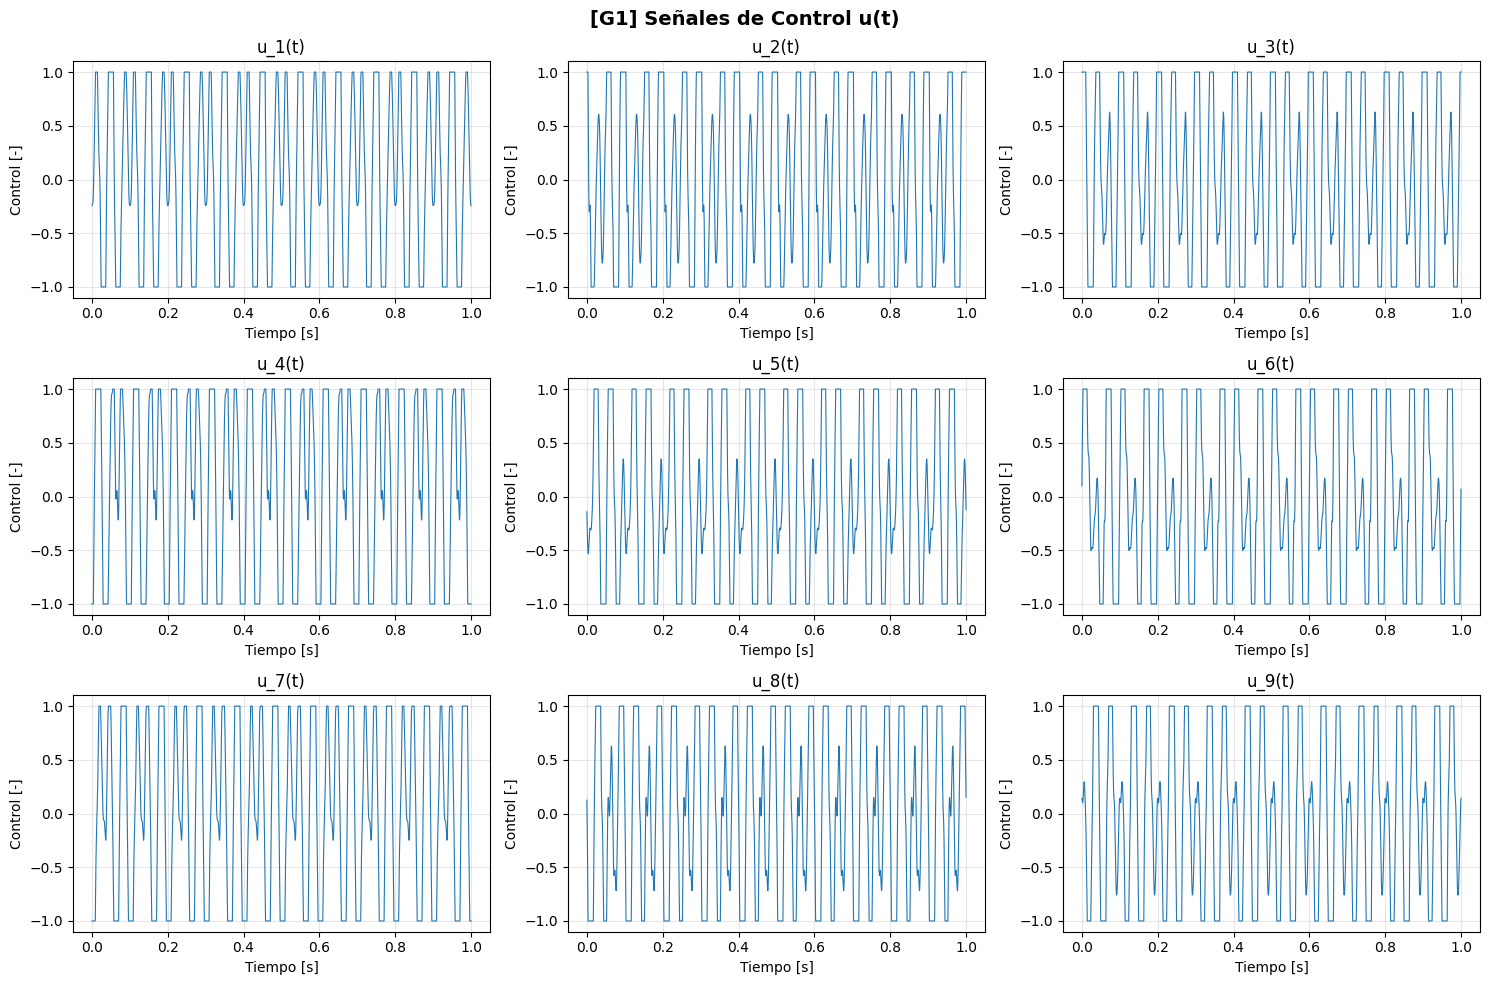

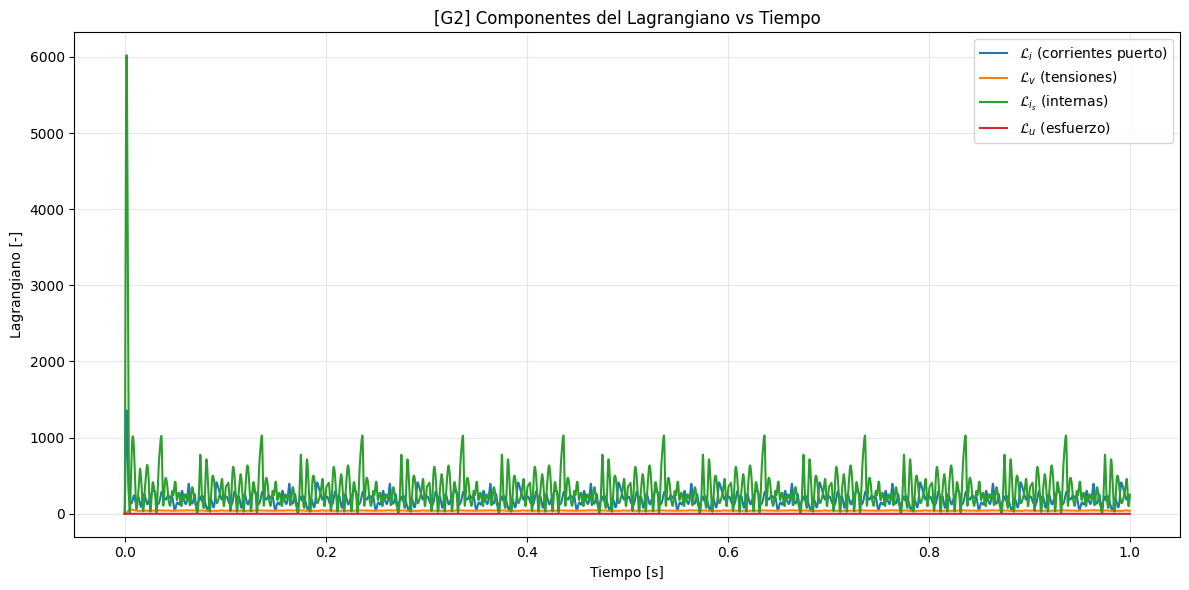

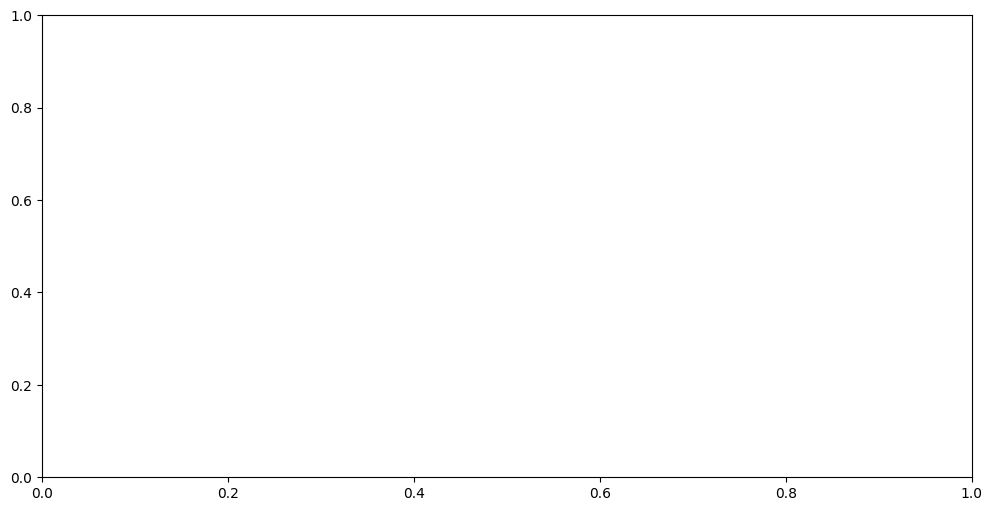

In [5]:
# ================================================================
# OCP MMCC - GPU + Unidades SI + PF & Potencia + Warm-Start + x0 desde referencias
# ================================================================
import numpy as np                                   # [GEN] Utilidades numéricas (post-proceso)
import torch                                          # [GEN] Autodiff + GPU
import torch.nn as nn                                 # [GEN] Parámetros entrenables
import matplotlib.pyplot as plt                       # [PLOT] Gráficos
import pandas as pd                                   # [IO] CSV
from typing import Tuple, Dict                        # [GEN] Tipado
import warnings                                       # [GEN] Silencio de warnings
warnings.filterwarnings('ignore')                     # [GEN] Ignorar warnings no críticos

# ------------------ [OPT] Dispositivo y semillas ------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # [OPT] Usa GPU si disponible
torch.manual_seed(42)                                                  # [OPT] Semilla fija torch
np.random.seed(42)                                                     # [OPT] Semilla fija numpy

# ===================== PARÁMETROS DEL SISTEMA =====================

# [REF] Señales externas (RMS; se convierten a pico dentro de compute_references)
T = 1.0                     # [REF] Horizonte [s]
nu_psi, nu_chi = 20.0, 30.0 # [REF] Frecuencias [Hz]
phi_psi, phi_chi = 0.0, 0.0 # [REF] Fases [rad]
A_psi, A_chi = 270.0, 311.0 # [REF] Amplitudes RMS [V]

# --- FACTOR DE POTENCIA Y POTENCIA OBJETIVO (opcional) ---
cos_phi_psi = 1.0                      # [REF] F1 = cos(phi_ψ); por defecto 1 (FP unitario)
cos_phi_chi = 0.85                     # [REF] F2 = cos(phi_χ) ∈ [0.5, 1]
P_target = None                        # [REF] P por fase [W]; si None, se usa I_ψ_base
I_psi_peak_base = 10.0                 # [REF] Amplitud pico de I_ψ si P_target es None [A pico]

# [DYN] Parámetros eléctricos
C = 2e-3                    # [DYN] Capacitancia [F]
L = 1e-3                    # [DYN] Inductancia [H]
R = 0.5                     # [DYN] Resistencia [Ω]

# ------------------ [UNIT FIX] Nominal y límites en VOLTIOS/AMPERES ------------------
V_C_nom = 300.0             # [UNIT FIX][DYN] Tensión nominal por capacitor [V]
v_C_min = 0.9 * V_C_nom     # [UNIT FIX][OBST] 270 V
v_C_max = 1.1 * V_C_nom     # [UNIT FIX][OBST] 330 V
i_s_min, i_s_max = -20.0, 20.0  # [OBST] Límites de corrientes [A]

# [CTRL] Límites del control adimensional
u_min, u_max = -1.0, 1.0    # [CTRL] Clipping duro

# [LAGR] Pesos (suman 1)
lambda_i, lambda_v, lambda_is, lambda_u = 0.35, 0.25, 0.20, 0.20  # [LAGR] Pesos

# [LAGR] Escalas (se calcularán por Def. 1 más abajo)
E_i_N = E_v_N = E_is_N = E_u_N = None                              # [LAGR] Placeholders

# [CTRL] Control armónico
N = 3                         # [CTRL] Orden armónico
Theta_max = 10.0              # [CTRL] Cota de norma ||θ||₂

# [INT] Discretización temporal
kappa = 60                                                    # [INT] Sobremuestreo
f_max = N * (nu_psi + nu_chi)                                 # [INT] f_max
h = 1.0 / (kappa * f_max)                                     # [INT] Paso
K_steps = int(T / h)                                          # [INT] Pasos

# [OPT] Entrenamiento
lr, max_epochs, grad_clip, tol = 0.003, 200, 1.0, 1e-4        # [OPT] LR reducido por warm-start
tau_smooth = 0.1                                              # [OPT] Suavizado smooth-max

print("="*60)
print("CONFIGURACIÓN DEL SISTEMA")
print("="*60)
print(f"Orden armónico N={N}, generando hasta {2*N*(N+1)} frecuencias")
print(f"Paso temporal h={h:.6f}s, κ={kappa}, f_max={f_max:.1f}Hz")
print(f"Parámetros eléctricos: C={C:.3e}F, L={L:.3e}H, R={R:.2f}Ω")
print(f"Amplitudes RMS: A_ψ={A_psi}V, A_χ={A_chi}V")
print(f"Límites: v_C∈[{v_C_min:.1f},{v_C_max:.1f}] V, i_s∈[{i_s_min:.1f},{i_s_max:.1f}] A")
print(f"Θ_max={Theta_max}, lr={lr}, épocas_max={max_epochs}")
print("="*60)

# ===================== MATRICES DEL SISTEMA =====================

# [DYN] Matriz A 6×9 (puertos→ramas)
A = torch.tensor([
    [1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [-1, 0, 0, -1, 0, 0, -1, 0, 0],
    [0, -1, 0, 0, -1, 0, 0, -1, 0],
    [0, 0, -1, 0, 0, -1, 0, 0, -1]
], dtype=torch.float32, device=device)                                # [DYN] En device

# [DYN] K = (8I - 11ᵀ)/9 y proyector al núcleo de A
ones = torch.ones(9, 1, device=device)                                # [DYN] Vector de unos
K = (8 * torch.eye(9, device=device) - ones @ ones.T) / 9             # [DYN] Acoplamientos
A_pinv = torch.pinverse(A)                                             # [DYN] A†
P_ker = torch.eye(9, device=device) - A_pinv @ A                       # [DYN] Proyector núcleo

# ===================== CONTROL ARMÓNICO =====================

def build_harmonic_frequencies(N:int, nu_psi:float, nu_chi:float)->torch.Tensor:
    """[CTRL] Ω_N sin duplicados, en device."""
    freqs=set()
    for m in range(N+1):
        for n in range(N+1):
            f1=abs(m*nu_psi+n*nu_chi); f2=abs(m*nu_psi-n*nu_chi)
            if f1>0: freqs.add(f1)
            if f2>0: freqs.add(f2)
    return torch.tensor(sorted(freqs), dtype=torch.float32, device=device)

omega_N = build_harmonic_frequencies(N, nu_psi, nu_chi)                 # [CTRL] Ω_N
print(f"[CTRL] Frecuencias armónicas ({len(omega_N)}): {omega_N.detach().cpu().numpy()}")

class HarmonicControl(nn.Module):
    """[CTRL] u_j(t)=u_{j,0}+Σ_ω(a_{j,ω}cos(2πωt)+b_{j,ω}sin(2πωt)), con clipping."""
    def __init__(self, omega_N:torch.Tensor):
        super().__init__()
        self.register_buffer('omega_N', omega_N)                        # [CTRL] Buffer no optimizable
        nf = omega_N.numel()                                            # [CTRL] #freqs
        self.u0 = nn.Parameter(torch.zeros(9, device=device))           # [CTRL] DC
        self.a_coeff = nn.Parameter(torch.randn(9, nf, device=device)*0.1) # [CTRL] Cos
        self.b_coeff = nn.Parameter(torch.randn(9, nf, device=device)*0.1) # [CTRL] Sin
        with torch.no_grad():                                           # [CTRL] Inicialización con fundamentales
            idx_psi = torch.argmin(torch.abs(self.omega_N - float(nu_psi)))
            idx_chi = torch.argmin(torch.abs(self.omega_N - float(nu_chi)))
            self.a_coeff[:, idx_psi] = 0.3
            self.a_coeff[:, idx_chi] = 0.2
    def forward(self, t:torch.Tensor)->torch.Tensor:
        """[CTRL] Evalúa u_θ(t) en device y hace clip a [u_min,u_max]."""
        if t.dim()==0: t = t.unsqueeze(0)                               # [CTRL] (B,)
        u = self.u0.unsqueeze(0).expand(t.shape[0], -1)                 # [CTRL] DC → (B,9)
        phases = 2*torch.pi*t.unsqueeze(1)*self.omega_N.unsqueeze(0)    # [CTRL] (B,nf)
        u = u + (torch.cos(phases) @ self.a_coeff.T)                    # [CTRL] Cos acumulado
        u = u + (torch.sin(phases) @ self.b_coeff.T)                    # [CTRL] Sin acumulado
        u = torch.clamp(u, u_min, u_max)                                # [CTRL] Clipping duro componente a componente
        return u.squeeze(0) if t.shape[0]==1 else u                     # [CTRL] Squeeze si escalar
    def project_theta(self, theta_max:float):
        """[OPT] Proyección ||θ||₂≤Θ_max (escala in-place si excede)."""
        with torch.no_grad():
            theta = torch.cat([self.u0.flatten(), self.a_coeff.flatten(), self.b_coeff.flatten()])
            nrm = torch.norm(theta)
            if nrm > theta_max:
                scale = theta_max/(nrm+1e-12)
                self.u0.mul_(scale); self.a_coeff.mul_(scale); self.b_coeff.mul_(scale)

# ===================== REFERENCIAS TRIFÁSICAS (con PF y potencia) =====================

def compute_references(t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """[REF] v* (V pico) e i* (A pico) con PFs dados y balance Aψ Iψ cosφψ = Aχ Iχ cosφχ."""
    # --- tensiones (RMS→pico) ---
    A_psi_peak = torch.tensor(A_psi, device=device) * torch.sqrt(torch.tensor(2.0, device=device))
    A_chi_peak = torch.tensor(A_chi, device=device) * torch.sqrt(torch.tensor(2.0, device=device))
    phase_shifts = torch.tensor([0.0, -2*torch.pi/3, 2*torch.pi/3], device=device)
    phase_psi = 2*torch.pi*torch.tensor(nu_psi, device=device)*t + torch.tensor(phi_psi, device=device)
    phase_chi = 2*torch.pi*torch.tensor(nu_chi, device=device)*t + torch.tensor(phi_chi, device=device)
    v_psi_star = A_psi_peak * torch.cos(phase_psi + phase_shifts)      # [REF] V pico
    v_chi_star = A_chi_peak * torch.cos(phase_chi + phase_shifts)      # [REF] V pico
    v_star = torch.cat([v_psi_star, v_chi_star])                        # [REF] ℝ⁶

    # --- corrientes que satisfacen la ecuación de potencia ---
    cpsi = torch.tensor(cos_phi_psi, device=device)
    cchi = torch.tensor(cos_phi_chi, device=device)
    if P_target is not None:
        # P por fase en RMS: I_RMS = P/(A_RMS cosφ) ⇒ I_pico = I_RMS*√2
        I_psi_peak = (torch.tensor(P_target, device=device) / (torch.tensor(A_psi, device=device)*cpsi)) * torch.sqrt(torch.tensor(2.0, device=device))
        I_chi_peak = (torch.tensor(P_target, device=device) / (torch.tensor(A_chi, device=device)*cchi)) * torch.sqrt(torch.tensor(2.0, device=device))
    else:
        I_psi_peak = torch.tensor(I_psi_peak_base, device=device)
        ratio = (torch.tensor(A_psi, device=device)*cpsi) / (torch.tensor(A_chi, device=device)*cchi)
        I_chi_peak = I_psi_peak * ratio
    phi_i_psi = torch.arccos(cpsi)                                      # [REF] ángulos de FP
    phi_i_chi = torch.arccos(cchi)
    i_psi_star = I_psi_peak * torch.cos(phase_psi - phi_i_psi + phase_shifts)  # [REF] A pico
    i_chi_star = I_chi_peak * torch.cos(phase_chi - phi_i_chi + phase_shifts)  # [REF] A pico
    i_star = torch.cat([i_psi_star, i_chi_star])                         # [REF] ℝ⁶
    return v_star, i_star

# --------- [LAGR] Escalas E_{·,N} por Def.1 con unidades SI ----------
@torch.no_grad()
def compute_nominal_scales_def1(n_samples:int=2048):
    """[LAGR] E_i_N (A), E_v_N (V), E_is_N (A), E_u_N (V) usando DC+peak/√2."""
    # [REF] Malla temporal
    t = torch.linspace(0.0, T, n_samples, device=device)
    V_list, I_list = [], []
    for tk in t:
        v_star, i_star = compute_references(tk)
        V_list.append(v_star); I_list.append(i_star)
    V = torch.stack(V_list, dim=0)                            # [REF] (n,6) [V]
    I = torch.stack(I_list, dim=0)                            # [REF] (n,6) [A]
    # [LAGR] e_i - escala por i* (A)
    i_dc   = I.mean(dim=0)
    i_peak = (I - i_dc).abs().max(dim=0).values
    E_i = torch.sqrt(i_dc.norm()**2 + 0.5*(i_peak.norm()**2))
    # [LAGR] e_u - escala por y=A^T v* (V)
    Y = (A.T @ V.T).T                                         # [LAGR] (n,9) [V]
    y_dc   = Y.mean(dim=0)
    y_peak = (Y - y_dc).abs().max(dim=0).values
    E_u = torch.sqrt(y_dc.norm()**2 + 0.5*(y_peak.norm()**2))
    # ---------------- [UNIT FIX] e_v: ripple ±10% de V_C_nom en VOLTIOS ----------------
    rv_peak = (0.1 * torch.tensor(V_C_nom, device=device)) * torch.ones(9, device=device)  # [UNIT FIX][LAGR] 30 V pico por celda
    E_v = torch.sqrt(0.5 * (rv_peak.norm()**2))                # [UNIT FIX][LAGR] DC≈0 ⇒ ||peak||/√2
    # [LAGR] e_is - fracción de E_i (A)
    E_is = 0.3 * E_i
    return float(E_i.item()), float(E_v.item()), float(E_is.item()), float(E_u.item())

# [LAGR] Inicializa escalas
E_i_N, E_v_N, E_is_N, E_u_N = compute_nominal_scales_def1()
print(f"[LAGR] Escalas Def.1: E_i={E_i_N:.3f} A, E_v={E_v_N:.3f} V, E_is={E_is_N:.3f} A, E_u={E_u_N:.3f} V")

# --- Chequeo de la ecuación Aψ Iψ cosφψ = Aχ Iχ cosφχ (en RMS) ---
with torch.no_grad():
    v0, i0_peak = compute_references(torch.tensor(0.0, device=device))
    Ipsi_rms = (i0_peak[:3].abs().max() / np.sqrt(2)).item()
    Ichi_rms = (i0_peak[3:].abs().max() / np.sqrt(2)).item()
    Ppsi = A_psi * Ipsi_rms * cos_phi_psi
    Pchi = A_chi * Ichi_rms * cos_phi_chi
    print(f"[CHECK] Aψ Iψ cosφψ = {Ppsi:.3f},  Aχ Iχ cosφχ = {Pchi:.3f},  diferencia = {abs(Ppsi-Pchi):.3e}")

# ===================== DINÁMICA =====================

def system_dynamics(x:torch.Tensor, u:torch.Tensor, t:float)->torch.Tensor:
    """[DYN] ẋ=f(t,x,u) con unidades SI y términos dimensionalmente consistentes."""
    v_C = x[:9]                                                  # [DYN] v_C [V]
    i_s = x[9:]                                                  # [DYN] i_s [A]
    v_star, _ = compute_references(torch.tensor(t, device=device))  # [REF] v* [V]
    dv_C_dt = (1.0/C) * (i_s * u)                                # [DYN] C⁻¹ diag(i_s)u ⇒ V/s
    resistive = -R * i_s                                         # [DYN] −R i_s ⇒ V
    source    = A.T @ v_star                                     # [DYN] A^T v* ⇒ V
    coupling  = K @ (v_C * u)                                    # [DYN] K diag(v_C)u ⇒ V
    di_s_dt = (1.0/L) * (resistive + source - coupling)          # [DYN] L⁻¹(voltaje equivalente) ⇒ A/s
    return torch.cat([dv_C_dt, di_s_dt])                         # [DYN] 18D

# ===================== RK4 =====================

def rk4_step(f, x:torch.Tensor, u:torch.Tensor, h:float, t:float)->torch.Tensor:
    """[INT] Paso RK4 clásico (error O(h^5))."""
    k1 = f(x,             u, t)               # [INT] k1
    k2 = f(x + 0.5*h*k1,  u, t + 0.5*h)       # [INT] k2
    k3 = f(x + 0.5*h*k2,  u, t + 0.5*h)       # [INT] k3
    k4 = f(x +     h*k3,  u, t + h)           # [INT] k4
    return x + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)  # [INT] Media ponderada

# ===================== RESIDUOS Y LAGRANGIANO =====================

def compute_residuals(x:torch.Tensor, u:torch.Tensor, t:float)->Dict[str, torch.Tensor]:
    """[LAGR] e_i, e_v, e_is, e_u con unidades correctas."""
    v_C = x[:9]; i_s = x[9:]                                      # [LAGR] Partición
    v_star, i_star = compute_references(torch.tensor(t, device=device))  # [REF] v*, i*
    e_i  = A @ i_s - i_star                                       # [LAGR] A i_s − i* [A]
    v_C_star = torch.full((9,), V_C_nom, device=device)            # [UNIT FIX][LAGR] v_C* = 300 V
    e_v  = v_C - v_C_star                                          # [UNIT FIX][LAGR] [V]
    e_is = P_ker @ i_s                                             # [LAGR] Corrientes internas [A]
    e_u  = (A.T @ v_star) - (v_C * u)                              # [UNIT FIX][LAGR] [V]
    return {'e_i': e_i, 'e_v': e_v, 'e_is': e_is, 'e_u': e_u}

def compute_lagrangian_components(resid:Dict[str, torch.Tensor])->Dict[str, torch.Tensor]:
    """[LAGR] Componentes normalizadas por Def.1 (adimensionales)."""
    L_i  = lambda_i  * (torch.norm(resid['e_i']) **2)  / (E_i_N  **2)  # [LAGR]
    L_v  = lambda_v  * (torch.norm(resid['e_v']) **2)  / (E_v_N  **2)  # [LAGR]
    L_is = lambda_is * (torch.norm(resid['e_is'])**2)  / (E_is_N **2)  # [LAGR]
    L_u  = lambda_u  * (torch.norm(resid['e_u']) **2)  / (E_u_N  **2)  # [LAGR]
    return {'L_i': L_i, 'L_v': L_v, 'L_is': L_is, 'L_u': L_u}

# ===================== OBSTÁCULO Y SMOOTH-MAX =====================

def obstacle_function(x:torch.Tensor)->torch.Tensor:
    """[OBST] g(x)≥0 mide violación de cotas (0 si factible)."""
    v_C = x[:9]; i_s = x[9:]
    vC_low  = torch.relu(torch.tensor(v_C_min, device=device) - v_C)   # [OBST]
    vC_high = torch.relu(v_C - torch.tensor(v_C_max, device=device))   # [OBST]
    iS_low  = torch.relu(torch.tensor(i_s_min, device=device) - i_s)   # [OBST]
    iS_high = torch.relu(i_s - torch.tensor(i_s_max, device=device))   # [OBST]
    return torch.max(torch.cat([vC_low, vC_high, iS_low, iS_high]))    # [OBST] Máx. componente

def smooth_max(a:torch.Tensor, b:torch.Tensor, tau:float=0.1)->torch.Tensor:
    """[OPT] smax(a,b)=τ log(exp(a/τ)+exp(b/τ))."""
    return tau * torch.logsumexp(torch.stack([a/tau, b/tau]), dim=0)

# ===================== WARM–START (LS sobre base armónica) =====================

@torch.no_grad()
def warm_start_harmonic(control: HarmonicControl, n_samples:int=4096):
    """[OPT][CTRL] Ajuste LS: u_θ(t) ≈ (A^T v*(t))/V_C_nom en la base armónica."""
    t = torch.linspace(0.0, T, n_samples, device=device)                           # [REF] malla
    cosF = torch.cos(2*torch.pi*t.unsqueeze(1) * control.omega_N.unsqueeze(0))     # [CTRL] n×nf
    sinF = torch.sin(2*torch.pi*t.unsqueeze(1) * control.omega_N.unsqueeze(0))     # [CTRL] n×nf
    Phi  = torch.cat([torch.ones(n_samples,1,device=device), cosF, sinF], dim=1)   # [CTRL] n×(1+2nf)
    Y = []
    for tk in t:
        v_star, _ = compute_references(tk)
        y = (A.T @ v_star) / torch.tensor(V_C_nom, device=device)                  # [CTRL] objetivo
        Y.append(y)
    Y = torch.stack(Y, dim=0)                                                      # [CTRL] n×9
    G   = Phi.T @ Phi
    RHS = Phi.T @ Y
    epsI = 1e-6 * torch.eye(G.shape[0], device=device)
    Beta = torch.linalg.solve(G + epsI, RHS)                                       # [OPT]
    nf = cosF.shape[1]
    control.u0.copy_(Beta[0, :])                                                   # [CTRL]
    control.a_coeff.copy_(Beta[1:1+nf, :].T)                                       # [CTRL]
    control.b_coeff.copy_(Beta[1+nf:, :].T)                                        # [CTRL]
    control.project_theta(Theta_max)                                               # [OPT]

# ===================== SIMULACIÓN FORWARD =====================

def simulate_system(control:HarmonicControl, x0:torch.Tensor, return_trajectory:bool=True)->Dict[str, torch.Tensor]:
    """[INT] Integra y acumula costo/obstáculo (device)."""
    x = x0.clone()
    if return_trajectory:
        x_traj=[x0.clone()]; u_traj=[]; Lc={'L_i':[], 'L_v':[], 'L_is':[], 'L_u':[]}
    z_total = torch.tensor(0.0, device=device, requires_grad=True)       # [COST]
    g_max   = torch.tensor(-float('inf'), device=device)                 # [OBST]
    for k in range(K_steps):
        t_k = k*h                                                        # [INT]
        u_k = control(torch.tensor(t_k, device=device))                  # [CTRL]
        resid = compute_residuals(x, u_k, t_k)                           # [LAGR]
        comps = compute_lagrangian_components(resid)                     # [LAGR]
        L_k = sum(comps.values())                                        # [LAGR]
        z_total = z_total + L_k*h                                        # [COST]
        g_k = obstacle_function(x)                                       # [OBST]
        g_max = smooth_max(g_max, g_k, tau_smooth)                       # [OBST]
        x = rk4_step(system_dynamics, x, u_k, h, t_k)                    # [INT]
        if return_trajectory:
            x_traj.append(x.clone()); u_traj.append(u_k.clone())         # [INT]
            for key in Lc: Lc[key].append(comps[key].clone())            # [LAGR]
    out={'z_total': z_total, 'g_max': g_max}
    if return_trajectory:
        out['x_traj']=torch.stack(x_traj); out['u_traj']=torch.stack(u_traj)
        out['L_components']={k:torch.stack(v) for k,v in Lc.items()}
    return out

# ===================== OPTIMIZACIÓN =====================

control = HarmonicControl(omega_N).to(device)                            # [OPT] Control en device

# ------------------ Estado inicial desde referencias ------------------
with torch.no_grad():
    t0 = torch.tensor(0.0, device=device)
    _, i_star0_peak = compute_references(t0)                              # [REF] i* (pico)
    i_star0_rms = i_star0_peak / torch.sqrt(torch.tensor(2.0, device=device))  # [REF] RMS
    i_s0 = A_pinv @ i_star0_rms                                          # [DYN] ramas compatibles
    i_s0 = torch.clamp(i_s0, i_s_min, i_s_max)                           # [OBST] proyección suave
    v_C0 = torch.full((9,), V_C_nom, device=device)                      # [REF] v_C* DC nominal
    x0 = torch.cat([v_C0, i_s0])                                         # [OPT] x(0)

# —— WARM–START (clave para que la época 0 no explote) ——
warm_start_harmonic(control, n_samples=4096)                             # [OPT] Ajuste LS

optimizer = torch.optim.Adam(control.parameters(), lr=lr)               # [OPT] Adam
loss_history, grad_norm_history = [], []                                 # [OPT] Historial

print("\n[OPT] Iniciando optimización...")
print("="*60)
for epoch in range(max_epochs):
    results = simulate_system(control, x0, return_trajectory=False)      # [OPT] Forward
    loss_core = smooth_max(results['g_max'], results['z_total'], tau_smooth)  # [OPT] smax(g_max, z)
    theta_cat = torch.cat([control.u0.flatten(), control.a_coeff.flatten(), control.b_coeff.flatten()])  # [OPT]
    theta_norm = torch.norm(theta_cat)                                   # [OPT]
    theta_penalty = torch.relu(theta_norm - Theta_max)**2                # [OPT]
    total_loss = loss_core + 0.1*theta_penalty                           # [OPT]
    optimizer.zero_grad(); total_loss.backward()                         # [OPT] Backprop
    grad_norm = torch.sqrt(sum([(p.grad.norm()**2) for p in control.parameters() if p.grad is not None]))  # [OPT]
    torch.nn.utils.clip_grad_norm_(control.parameters(), grad_clip)      # [OPT]
    optimizer.step(); control.project_theta(Theta_max)                   # [OPT]
    loss_history.append(float(total_loss.detach().cpu().item()))
    grad_norm_history.append(float(grad_norm.detach().cpu().item()))
    if epoch % 20 == 0:
        print(f"[OPT] Época {epoch:3d}: loss={total_loss.item():.6f}, z={results['z_total'].item():.6f}, "
              f"g_max={results['g_max'].item():.6f}, ||∇||={grad_norm.item():.6f}, ||θ||={theta_norm.item():.3f}")
    if grad_norm < tol:
        print(f"[OPT] Convergencia alcanzada en época {epoch} (||∇|| < {tol})")
        break
print("="*60); print("[OPT] Optimización completada\n")

# ===================== EVALUACIÓN FINAL =====================

print("Evaluando solución óptima...")
with torch.no_grad():
    final_results = simulate_system(control, x0, return_trajectory=True)

# -------- Post-proceso/plots en CPU --------
x_traj = final_results['x_traj'].detach().cpu().numpy()
u_traj = final_results['u_traj'].detach().cpu().numpy()
L_components = {k:v.detach().cpu().numpy() for k,v in final_results['L_components'].items()}

# [COST] Integrales
integral_L_i  = np.trapz(L_components['L_i'],  dx=h)
integral_L_v  = np.trapz(L_components['L_v'],  dx=h)
integral_L_is = np.trapz(L_components['L_is'], dx=h)
integral_L_u  = np.trapz(L_components['L_u'],  dx=h)
J_total = integral_L_i + integral_L_v + integral_L_is + integral_L_u

# [OBST] Validación de cotas
v_C_traj = x_traj[:, :9]; i_s_traj = x_traj[:, 9:]
v_C_min_viol = max(0.0, v_C_min - np.min(v_C_traj))
v_C_max_viol = max(0.0, np.max(v_C_traj) - v_C_max)
i_s_min_viol = max(0.0, i_s_min - np.min(i_s_traj))
i_s_max_viol = max(0.0, np.max(i_s_traj) - i_s_max)

# [CTRL] % de saturación
sat_frac = np.mean((u_traj <= (u_min + 1e-6)) | (u_traj >= (u_max - 1e-6))) * 100.0

# ===================== TABLA =====================

print("\n" + "="*60)
print("TABLA DE INTEGRALES DE COSTO (normalización Def.1, unidades SI)")
print("="*60)
print(f"∫L_i dt   = {integral_L_i:.6f}  (Ajuste de corrientes de puerto)")
print(f"∫L_v dt   = {integral_L_v:.6f}  (Ripple de tensiones v_C en V)")
print(f"∫L_is dt  = {integral_L_is:.6f}  (Corrientes internas)")
print(f"∫L_u dt   = {integral_L_u:.6f}  (Esfuerzo de control en V)")
print("-"*60)
print(f"J total   = {J_total:.6f}")
print("="*60)

print("\n" + "="*60)
print("VALIDACIÓN DE RESTRICCIONES (VOLTIOS/AMPERES)")
print("="*60)
print(f"v_C ∈ [{np.min(v_C_traj):.2f}, {np.max(v_C_traj):.2f}] V  límites [{v_C_min:.1f}, {v_C_max:.1f}] V  | viol_inf={v_C_min_viol:.6f} V, viol_sup={v_C_max_viol:.6f} V")
print(f"i_s ∈ [{np.min(i_s_traj):.2f}, {np.max(i_s_traj):.2f}] A  límites [{i_s_min:.1f}, {i_s_max:.1f}] A  | viol_inf={i_s_min_viol:.6f} A, viol_sup={i_s_max_viol:.6f} A")
print(f"Control: clipping activo en {sat_frac:.2f}% de muestras")
print("="*60)

# ===================== GRÁFICOS =====================

plt.rcParams['figure.figsize'] = (15,10); plt.rcParams['font.size']=10
t_plot = np.arange(u_traj.shape[0]) * h

# [PLOT] G1 Control
fig1, axes1 = plt.subplots(3,3, figsize=(15,10))
fig1.suptitle('[G1] Señales de Control u(t)', fontsize=14, fontweight='bold')
for j in range(9):
    ax = axes1[j//3, j%3]; ax.plot(t_plot, u_traj[:, j], linewidth=0.8)
    ax.set_title(f'u_{j+1}(t)'); ax.set_xlabel('Tiempo [s]'); ax.set_ylabel('Control [-]')
    ax.grid(True, alpha=0.3); ax.set_ylim([u_min-0.1, u_max+0.1])
plt.tight_layout(); plt.savefig('G1_control_signals.png', dpi=150); print("[IO] Guardado: G1_control_signals.png")

# [PLOT] G2 Lagrangiano
fig2, ax2 = plt.subplots(figsize=(12,6))
ax2.plot(t_plot, L_components['L_i'],  label='$\\mathcal{L}_i$ (corrientes puerto)', linewidth=1.5)
ax2.plot(t_plot, L_components['L_v'],  label='$\\mathcal{L}_v$ (tensiones)',         linewidth=1.5)
ax2.plot(t_plot, L_components['L_is'], label='$\\mathcal{L}_{i_s}$ (internas)',      linewidth=1.5)
ax2.plot(t_plot, L_components['L_u'],  label='$\\mathcal{L}_u$ (esfuerzo)',          linewidth=1.5)
ax2.set_title('[G2] Componentes del Lagrangiano vs Tiempo'); ax2.set_xlabel('Tiempo [s]'); ax2.set_ylabel('Lagrangiano [-]')
ax2.legend(loc='upper right'); ax2.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig('G2_lagrangian_components.png', dpi=150); print("[IO] Guardado: G2_lagrangian_components.png")

# [PLOT] G3 Corriente promedio
i_s_mean = np.mean(i_s_traj, axis=1)
fig3, ax3 = plt.subplots(figsize=(12,6))
ax3.plot(t_plot, i_s_mean, linewidth=2)
ax3.set_title('[G3] Promedio de Corrientes de Rama $\\bar{i}_s(t)$'); ax3.set_xlabel('Tiempo [s]'); ax3.set_ylabel('Corriente Promedio [A]')
ax3.grid(True, alpha=0.3); ax3.axhline(y=0, linestyle='--', alpha=0.5)
plt.tight_layout(); plt.savefig('G3_mean_current.png', dpi=150); print("[IO] Guardado: G3_mean_current.png")

# [PLOT] G4 Estados
fig4, (ax4_v, ax4_i) = plt.subplots(2,1, figsize=(15,10))
for j in range(9):
    ax4_v.plot(t_plot, v_C_traj[:-1, j], linewidth=1, label=f'$v_{{C,{j+1}}}$')
ax4_v.axhline(y=v_C_min, linestyle='--', alpha=0.5, label='Límites')
ax4_v.axhline(y=v_C_max, linestyle='--', alpha=0.5)
ax4_v.set_title('[G4a] Tensiones de Capacitores $v_C(t)$'); ax4_v.set_xlabel('Tiempo [s]'); ax4_v.set_ylabel('Tensión [V]')
ax4_v.legend(ncol=3, loc='upper right', fontsize=8); ax4_v.grid(True, alpha=0.3)
for j in range(9):
    ax4_i.plot(t_plot, i_s_traj[:-1, j], linewidth=1, label=f'$i_{{s,{j+1}}}$')
ax4_i.axhline(y=i_s_min, linestyle='--', alpha=0.5, label='Límites')
ax4_i.axhline(y=i_s_max, linestyle='--', alpha=0.5)
ax4_i.set_title('[G4b] Corrientes de Rama $i_s(t)$'); ax4_i.set_xlabel('Tiempo [s]'); ax4_i.set_ylabel('Corriente [A]')
ax4_i.legend(ncol=3, loc='upper right', fontsize=8); ax4_i.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig('G4_state_trajectories.png', dpi=150); print("[IO] Guardado: G4_state_trajectories.png")

# ===================== CSV =====================

data = {'t': t_plot, 'i_s_mean': i_s_mean,
        'L_i': L_components['L_i'], 'L_v': L_components['L_v'],
        'L_is': L_components['L_is'], 'L_u': L_components['L_u']}
for j in range(9): data[f'u_{j+1}']   = u_traj[:, j]
for j in range(9): data[f'v_C_{j+1}'] = v_C_traj[:-1, j]
for j in range(9): data[f'i_s_{j+1}'] = i_s_traj[:-1, j]
pd.DataFrame(data).to_csv('trajectories.csv', index=False, float_format='%.6f')
print("[IO] Guardado: trajectories.csv")

# ===================== REPORTE FINAL =====================

print("\n" + "="*60); print("REPORTE FINAL"); print("="*60)
with torch.no_grad():
    print("\nCoeficientes óptimos θ*:")
    print(f"  u_0: {control.u0.detach().cpu().numpy()}")
    theta_norm_star = torch.norm(torch.cat([control.u0, control.a_coeff.flatten(), control.b_coeff.flatten()])).item()
    print(f"  Norma ||θ*||₂ = {theta_norm_star:.4f}")
print(f"\nParámetros de discretización:\n  f_max = {f_max:.1f} Hz\n  h = {h:.6f} s\n  κ = {kappa}\n  Pasos totales = {K_steps}")
with torch.no_grad():
    P_psi_total = 0.0; P_chi_total = 0.0
    for k in range(K_steps):
        t_k = k*h
        v_star, i_star = compute_references(torch.tensor(t_k, device=device))
        P_psi_total += (v_star[:3] @ i_star[:3]).item()*h
        P_chi_total += (v_star[3:] @ i_star[3:]).item()*h
print(f"\nBalance de potencia (referencias):\n  ∫P_ψ dt = {P_psi_total:.3f} W·s\n  ∫P_χ dt = {P_chi_total:.3f} W·s\n  Desbalance = {abs(P_psi_total-P_chi_total):.6f} W·s")
print("\nArchivos generados:\n  - G1_control_signals.png\n  - G2_lagrangian_components.png\n  - G3_mean_current.png\n  - G4_state_trajectories.png\n  - trajectories.csv")
print("="*60); print("PROCESO COMPLETADO EXITOSAMENTE"); print("="*60)
